First we are going to use their funciton to read in the data

In [98]:
import numpy as np
from scipy.spatial import distance
import random
from matplotlib import pyplot as plt
from scipy.stats import nbinom as nb

In [2]:
# Copy the functions given by the PSET to save time and practice building upon functions written by other people
def read_data(infile):
    '''
    NOT MY FUNCTION
    read_data(infile)
    Read Lestrade's input file, w05-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

def initialize_at_true():
    '''
    NOT MY FUNCTION
    initialize_at_true():
    Returns the true mu centroids, and the true proportions;
    don't say I never gave you anything.
       mu[q,g]  : array of means for mixture q, gene g
       qp[q]    : mixture coefficient for mixture q
    '''
    qp = np.array([ 0.1, 0.2, 0.4, 0.2, 0.1 ])
    mu = np.array([[   30., 2000. ],
                   [ 2000., 2000. ],
                   [  300.,  300. ],
                   [   30.,   30. ],
                   [ 2000,    30. ]])
    return mu, qp


def visualize_data(data, mu, C, outpng):
    '''
    NOT MY FUNCTION
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    fig.savefig(outpng)

In [3]:
# Read in the data
data = read_data("w05-data.tbl")[1]

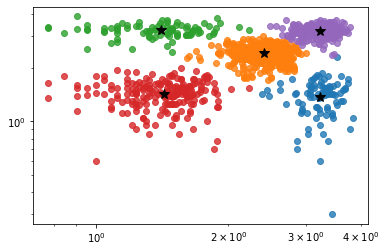

In [56]:
#! Need to add centroid_choices and interation end condition
def hard_k_means_cluster(k, data, centroid_choice, n):
    """Function to impliment k-means clustering with k clusters on a 2d numpy array of data, formatted such that 
    each row is a single c-dimensional data point, where z is the number of columns"""
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    
    best_total_sqr_dist = -1
    best_cluster_centroids = np.ones((k, num_cols))
    best_clustered_data = [[] for i in range(k)]
    for clustering_trial in range(n):
        
        # Initiate centroids in the way specified by the user
        if centroid_choice == "random":
            min_max_list = []
            centroids = np.ones((k, num_cols))
            # Get the min and max of data dimension
            for c in range(num_cols):
                min_max_list.append((data[:,c].min(), data[:,c].max()))

            # Create k random centroids with dimension values within the range of each data dimension
            for r in range(k):
                for c in range(num_cols):
                    centroids[r,c] = random.uniform(min_max_list[c][0],min_max_list[c][1])   
                    
        total_sqr_dist_list = []
        for epoch in range(100):
            ### Update the clusters###

            # Initiate an array where each index holds the new cluster identity of the data at the correspoinding row
            # index
            new_clusters = np.ones(num_rows, dtype=int)
            # Iterate over each row of the data
            for r in range(num_rows):
                # Get the identity closest centroid to data vector r
                centroid_dists = [distance.euclidean(i,data[r,:]) for i in centroids]
                total_sqr_dist_list.append(sum(centroid_dists)**2)
                closest_centroid = np.argmin(centroid_dists)
                # Add the centroid indentity to the array new_clusters
                new_clusters[r] = closest_centroid

            ### Update the centroid values###

            clustered_data = [[] for i in range(k)]
            # Create a list containing a list of cooredinates for the kh
            for idx in range(num_rows):
                clustered_data[new_clusters[idx]].append(data[idx,:])        

            for idx, cluster in enumerate(clustered_data):
                if len(cluster) == 0: continue
                else: 
                    centroids[idx,:] = np.mean(cluster, axis=0)         
        if min(total_sqr_dist_list) < best_total_sqr_dist or best_total_sqr_dist == -1:
            best_total_sqr_dist = min(total_sqr_dist_list)
            best_cluster_centroids = centroids
            best_clustered_data = clustered_data
        
    return best_clustered_data, best_cluster_centroids

def plot_clusters(clustered_data, centroids):
    fig, ax = plt.subplots()
    
    for cluster in clustered_data:
        data_1 = [i[0] for i in cluster]
        data_2 = [i[1] for i in cluster]
        ax.loglog(data_1, data_2, "s", marker="o", alpha=0.8 )

    for r in range(centroids.shape[0]):
        ax.loglog(centroids[r,0], centroids[r,1], marker="*", c="k", ms=10)
    
    return None

def plot_clusters_test(clustered_data, centroids):
    fig, ax = plt.subplots()
    
    for cluster in clustered_data:
        data_1 = [i[0] for i in cluster]
        data_2 = [i[1] for i in cluster]
        ax.scatter(data_1, data_2, "s", marker="o", alpha=0.8 )

    for r in range(centroids.shape[0]):
        ax.scatter(centroids[r,0], centroids[r,1], marker="*", c="k")
    
    return None
    
test_2, test_3 = hard_k_means_cluster(5, data, "random", 5)    
plot_clusters(test_2, test_3)



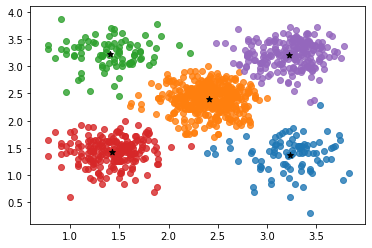

In [61]:
# The problem is with the log scale. I fixed it by transforming the data first
def plot_clusters_test(clustered_data, centroids):
    fig, ax = plt.subplots()
    
    for cluster in clustered_data:
        data_1 = [i[0] for i in cluster]
        data_2 = [i[1] for i in cluster]
        ax.scatter(data_1, data_2, marker="o", alpha=0.8 )

    for r in range(centroids.shape[0]):
        ax.scatter(centroids[r,0], centroids[r,1], marker="*", c="k")
    
    return None

plot_clusters_test(test_2, test_3)


__Need to figure out why k-means does not work__ 

In [168]:
def convert_nbinom_params(mean, dispersion):
    n = 1/dispersion
    p = 1/(1+mean*dispersion)
    
    return n, p

def get_post_probs(x, q, mu, disp):
    """Given an observation vector x, components vector q, mean vector mu, and dispersion value disp, calculates
    P(q|x,mu,disp) and returns a numpy array of the posterior probabilities for all q"""
    x_1 = x[0]
    x_2 = x[1]
    probs_list = []
    
    for q_idx in range(len(q)):       
        n1, p1 = convert_nbinom_params(mu[q_idx,0], disp)
        n2, p2 = convert_nbinom_params(mu[q_idx,1], disp)
        probs_list.append(q[q_idx]*nb.pmf(x_1, n1, p1)*nb.pmf(x_2, n2, p2))
        
    probs_list = np.array([i/sum(probs_list) for i in probs_list])
    
    return probs_list

# def update_component_vals(data, q, mu, disp, post_probs):
#     """Given an array of observation vectors data, components vector q, mean vector mu, dispersion value disp,
#     and vector of posterior probabilities post_probs, calculates the new means and mixture coefficients for 
#     each component"""
#     new_mu_list = []
#     new_mc_list = []
#     for q_idx in range(len(q)):
#         mu_num = sum[]
        
            
    

def fit_mixture_model(data, Q, disp, mu_choice, N):
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    
    best_total_probs = -1
    best_mix_coefs = np.ones((Q, num_rows))
    best_mus = np.ones((Q, num_cols))
    best_clustered_data = [[] for i in range(Q)]
    for fitting_trial in range(N):
        
        # Initiate means in the way specified by the user
        if mu_choice == "random":
            min_max_list = []
            mu_arr = np.ones((Q, num_cols))
            # Get the min and max of data dimension
            for c in range(num_cols):
                min_max_list.append((data[:,c].min(), data[:,c].max()))

            # Create q random mean vectors (one mean for each of the two genes) with dimension values within 
            # the range of each data dimension
            for q_idx in range(Q):
                for c_idx in range(num_cols):
                    mu_arr[q_idx, c_idx] = random.uniform(min_max_list[c_idx][0],min_max_list[c_idx][1]) 
        
        # Start with equal probability for all components
        comp_probs_arr = np.array([1/Q for i in range(Q)])
        post_probs_arr = np.ones((num_rows, Q))
        
        for epoch in range(1):
            
            ### Update the posterior probabilities ###
            for r_idx in range(num_rows):
                post_probs_arr[r_idx,:] = get_post_probs(data[r_idx,:], comp_probs_arr, mu_arr, disp)
            
            ### Update the mus ###
    return post_probs_arr
            


In [169]:
data = read_data("w05-data.tbl")[1]
test = fit_mixture_model(data, 5, 0.3, "random", 1)
test

array([[0.16533843, 0.12194239, 0.03661342, 0.67079924, 0.00530652],
       [0.50988165, 0.04863088, 0.16148811, 0.27726392, 0.00273545],
       [0.4530516 , 0.05877608, 0.1334775 , 0.35172766, 0.00296716],
       ...,
       [0.46546682, 0.05106938, 0.13548527, 0.34572526, 0.00225327],
       [0.46930768, 0.0507409 , 0.13741285, 0.3402673 , 0.00227126],
       [0.12250717, 0.13543264, 0.02562702, 0.71053176, 0.0059014 ]])

In [166]:
a = np.array([[1, 2, 3],[4, 5, 6]])
a

array([[1, 2, 3],
       [4, 5, 6]])